In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# some basic imports

import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [ ]:
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

In [ ]:
ROOT_PATH = "/content/drive/MyDrive/Road-Segmentation-Comp/ethz-cil-road-segmentation-2024"

In [ ]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(5, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()

In [ ]:
images = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'images'))[:, :, :, :3]
masks = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'groundtruth'))

In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

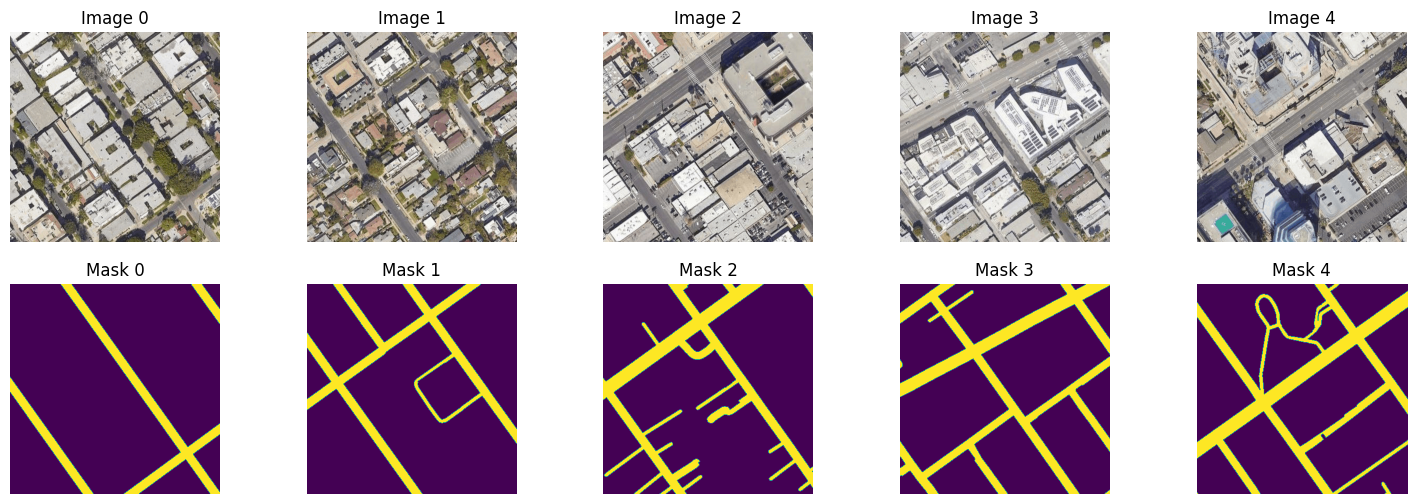

In [ ]:
show_first_n(train_images, train_masks)

In [ ]:
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    images = images[:,:,:,:3]

    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE

    patches = images.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()

In [ ]:
!ls

cnn_submission.csv  drive  sample_data


In [ ]:
def create_submission(labels, test_filenames, submission_filename):
    test_path = os.path.join(ROOT_PATH, 'training', 'images')
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), labels):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j, i, int(patch_array[i, j])))

In [ ]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)


class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, is_train, device, use_patches=True, resize_to=(400, 400)):
        self.is_train = is_train
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = train_images if self.is_train else val_images
        self.y = train_masks if self.is_train else val_masks
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))

    def __len__(self):
        return self.n_samples


def show_val_samples(x, y, y_hat, segmentation=False):
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

In [ ]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs):
    # training loop

    history = {}  # collects metrics at the end of each epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            y_hat = model(x)  # forward pass
            loss = loss_fn(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x)  # forward pass
                loss = loss_fn(y_hat, y)

                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())

    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [ ]:
class PatchCNN(nn.Module):
    # simple CNN for classification of patches
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),
                                 nn.BatchNorm2d(16),
                                 nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),
                                 nn.BatchNorm2d(32),
                                 nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),
                                 nn.BatchNorm2d(64),
                                 nn.Dropout(0.5),
                                 nn.Flatten(),
                                 nn.Linear(256, 10),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(10, 1),
                                 nn.Sigmoid())

    def forward(self, x):
        return self.net(x)

def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # automatically select device
train_dataset = ImageDataset(True, device)
val_dataset = ImageDataset(False, device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)
model = PatchCNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 5

Epoch 1/5:   0%|          | 0/562 [00:00<?, ?it/s]

	- loss = 0.49472740085735867
  	- val_loss = 0.4662577667286698
  	- acc = 0.764509995636991
  	- val_acc = 0.7970243335609705
  	- f1 = 0.45085246207421187
  	- val_f1 = 0.40355480057805665
 


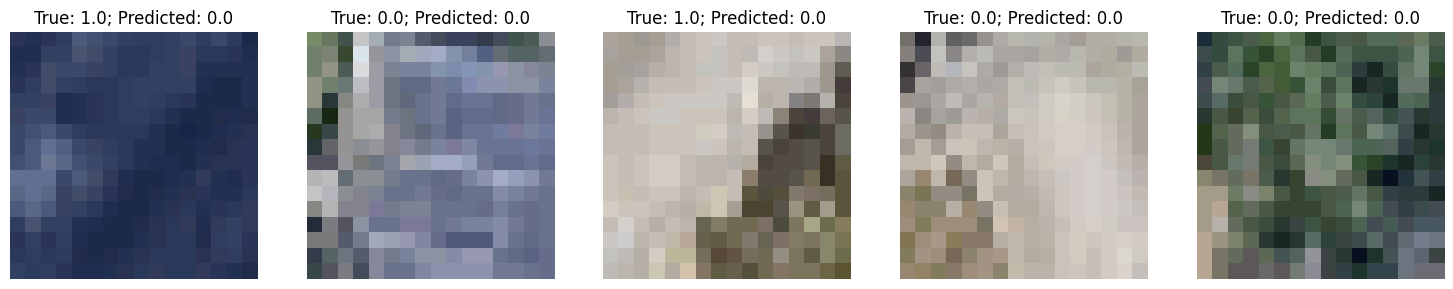

Epoch 2/5:   0%|          | 0/562 [00:00<?, ?it/s]

	- loss = 0.4600475946991469
  	- val_loss = 0.42752689123153687
  	- acc = 0.7924668528007018
  	- val_acc = 0.8020688047711279
  	- f1 = 0.42410940867144803
  	- val_f1 = 0.4396858915681005
 


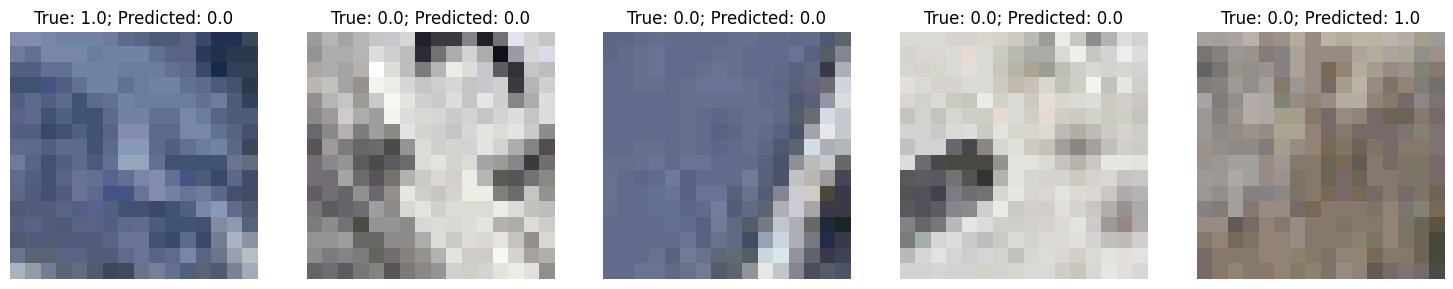

Epoch 3/5:   0%|          | 0/562 [00:00<?, ?it/s]

	- loss = 0.44908342926739797
  	- val_loss = 0.44942791319229236
  	- acc = 0.7977441390214017
  	- val_acc = 0.7960697425083375
  	- f1 = 0.4417821350727849
  	- val_f1 = 0.380868078178441
 


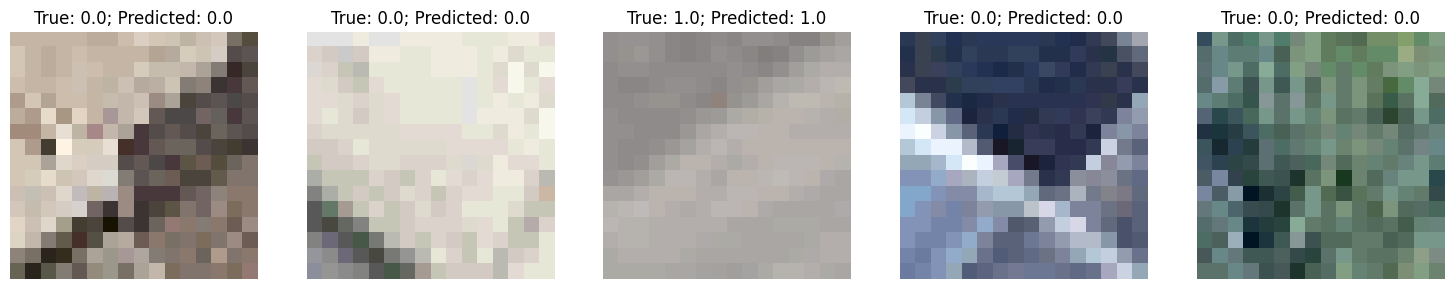

Epoch 4/5:   0%|          | 0/562 [00:00<?, ?it/s]

	- loss = 0.43783844042291
  	- val_loss = 0.45459371679265737
  	- acc = 0.8006167173173504
  	- val_acc = 0.7957603574638635
  	- f1 = 0.45208849482205565
  	- val_f1 = 0.36329977957256704
 


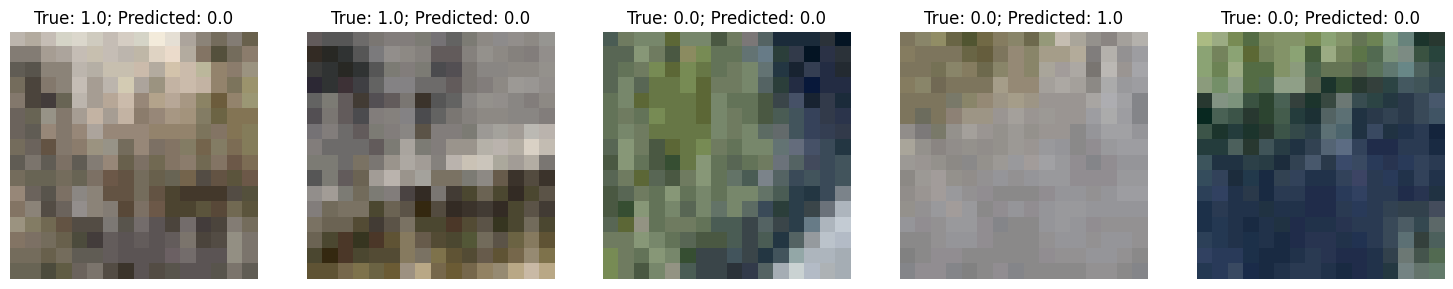

Epoch 5/5:   0%|          | 0/562 [00:00<?, ?it/s]

	- loss = 0.43286579555676075
  	- val_loss = 0.4171513856296808
  	- acc = 0.8017198952491598
  	- val_acc = 0.8106887059312471
  	- f1 = 0.4599786609524646
  	- val_f1 = 0.5084930835868615
 


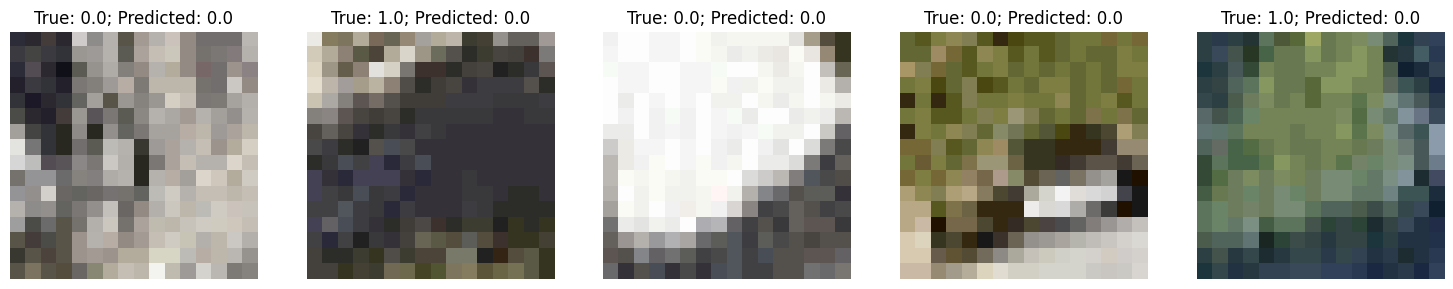

Finished Training


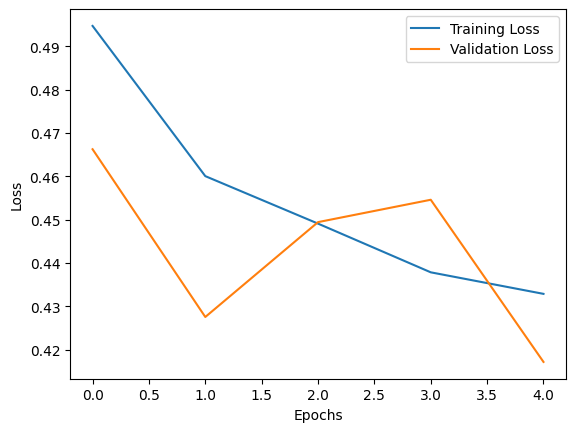

In [74]:
def f1_score_fn(y_hat, y):
  y_hat = y_hat.round().detach().cpu().numpy()
  y = y.round().detach().cpu().numpy()
  return f1_score(y, y_hat)

metric_fns = {'acc': accuracy_fn, 'f1': f1_score_fn}
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)